In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
import pandas as pd
import skimage.feature as feature
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import glob

# Criando Dataframes vazios de teste e treinamento

In [4]:
train_dataset = pd.DataFrame(columns=["image", "label"])

In [5]:
test_dataset = pd.DataFrame(columns=["image", "label"])

# Preenchendo o dataframe com a imagem e o nome do arquivo

In [6]:


for filename in glob.glob("Treino/*.bmp"):
    simpson = cv2.imread(filename)
    append_dataset = pd.DataFrame(data={"image": [simpson], "label": [filename[7:]]})
    train_dataset = pd.concat([train_dataset, append_dataset], ignore_index=True)

In [7]:
for filename in glob.glob("Teste/*.bmp"):
    simpson = cv2.imread(filename)
    append_dataset = pd.DataFrame(data={"image": [simpson], "label": [filename[6:]]})
    test_dataset = pd.concat([test_dataset, append_dataset], ignore_index=True)

# Removendo números e .bmp das labels das imagens

In [8]:
train_dataset["label"] = (
    train_dataset["label"].str.replace(".bmp", "").str.replace("\d+", "")
)
test_dataset["label"] = (
    test_dataset["label"].str.replace(".bmp", "").str.replace("\d+", "")
)

C:\Users\caeta\AppData\Local\Temp\ipykernel_43564\926591152.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_dataset["label"].str.replace(".bmp", "").str.replace("\d+", "")
C:\Users\caeta\AppData\Local\Temp\ipykernel_43564\926591152.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_dataset["label"].str.replace(".bmp", "").str.replace("\d+", "")


# Separando em X e Y de treinamento e teste

In [9]:
x_train = train_dataset["image"]
y_train = train_dataset["label"]
x_test = test_dataset["image"]
y_test = test_dataset["label"]

# Definindo Kernel para detecção de bordas

In [10]:
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

# Implementando um HOG modificado com filtro de cor amarela e detecção de bordas

In [11]:
class HOG:
    def describe(self, im, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        image = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
        lower = np.array([22, 93, 0], dtype="uint8")
        upper = np.array([45, 255, 255], dtype="uint8")
        mask = cv2.inRange(image, lower, upper)
        mask = cv2.filter2D(src=mask, ddepth=-1, kernel=kernel)

        im = cv2.resize(mask, (64, 128))

        fd, hog_image = feature.hog(
            im,
            orientations=9,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=(2, 2),
            visualize=True,
        )
        return fd, hog_image

# Separando as feautures de treinamento e teste

In [12]:
desc = HOG()

N_SAMPLES_TRAIN = 253
N_SAMPLES_TEST = 106

features = {"train": [], "test": []}
for img, lbl in zip(x_train[:N_SAMPLES_TRAIN], y_train[:N_SAMPLES_TRAIN]):

    feat, _ = desc.describe(img)
    features["train"].append(feat)

# Add to a dictionary
features["train"] = np.reshape(features["train"], (N_SAMPLES_TRAIN, -1))
print("Train Data: ", features["train"].shape)


for img, lbl in zip(x_test[:N_SAMPLES_TEST], y_test[:N_SAMPLES_TEST]):
    feat, _ = desc.describe(img)
    features["test"].append(feat)

# Add to a dictionary
features["test"] = np.reshape(features["test"], (N_SAMPLES_TEST, -1))
print("Test Data: ", features["test"].shape)

Train Data:  (253, 3780)
Test Data:  (106, 3780)


# Normalizando os dados para regularizar a distorção de valores

In [13]:
data = features["train"]
print(data[0])

print(np.unique(data[0]))

print("STD Scaler")
data_norm = preprocessing.StandardScaler().fit_transform(data)
print(np.unique(data_norm[0]))

print("MinMax Scaler")
data_norm = preprocessing.MinMaxScaler().fit_transform(data)
print(np.unique(data_norm[0]))

[0. 0. 0. ... 0. 0. 0.]
[0.         0.00120859 0.00131092 0.00173894 0.0022259  0.00263244
 0.0032773  0.00328406 0.00330104 0.00341881 0.00362063 0.00386476
 0.00408759 0.00434735 0.00478209 0.00567832 0.00612121 0.00624007
 0.00637762 0.00666892 0.00695445 0.0075197  0.00785303 0.00955419
 0.01148163 0.01226954 0.01407777 0.01647967 0.01736798 0.01793777
 0.01794441 0.01859418 0.0193852  0.02042543 0.02114601 0.02165744
 0.02265438 0.02295073 0.02331681 0.0234085  0.02417827 0.02423496
 0.02454161 0.02583356 0.02857488 0.032123   0.03375434 0.03377812
 0.03576986 0.0362247  0.03680939 0.03686301 0.03719621 0.03730132
 0.03769259 0.03779625 0.03838433 0.0395246  0.04009405 0.04323698
 0.04564848 0.04667848 0.0495728  0.05039409 0.05054991 0.05093677
 0.05106255 0.05138637 0.05141396 0.05173313 0.05176281 0.0518809
 0.05196763 0.05228203 0.05259887 0.0529377  0.05322128 0.05354327
 0.05382726 0.05442469 0.05487098 0.05493658 0.05495145 0.05506786
 0.05598145 0.05606355 0.05638916 0.057

In [14]:
data_norm_train = preprocessing.MinMaxScaler().fit_transform(features["train"])
data_norm_test = preprocessing.MinMaxScaler().fit_transform(features["test"])

# Importando os modelos KNN, Naive-Bayes, Regressão Logística e SVM para classificação, já com alguns parâmetros otimizados

In [15]:


max_iter = 10000

models = {}
models["KNN"] = KNeighborsClassifier(n_neighbors=16)
models["NB"] = MultinomialNB()
models["LR"] = LogisticRegression(max_iter=max_iter)
models["SVC"] = SVC(C=10, gamma=0.001, kernel="rbf")

In [16]:
def performance_evaluation(y_test, predictions, info_message, figsize=(18, 4)):

    print(f"Evaluation of ", info_message)
    print(f"{metrics.classification_report(y_test, predicted)}\n")
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()

# Avaliando a performance de cada modelo

------------------------
Treinando KNN
Evaluation of  KNN
              precision    recall  f1-score   support

        bart       0.55      0.80      0.65        35
      family       0.26      0.45      0.33        11
       homer       0.38      0.52      0.44        25
        lisa       1.00      0.08      0.14        13
      maggie       1.00      0.08      0.15        12
       marge       0.00      0.00      0.00        10

    accuracy                           0.45       106
   macro avg       0.53      0.32      0.29       106
weighted avg       0.53      0.45      0.39       106




c:\Users\caeta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\caeta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\caeta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

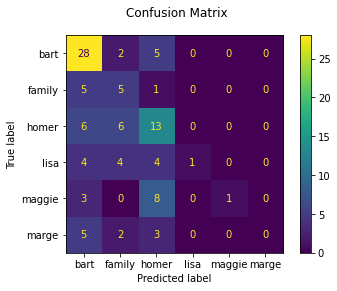

------------------------
Treinando NB
Evaluation of  NB
              precision    recall  f1-score   support

        bart       0.59      0.66      0.62        35
      family       0.28      0.45      0.34        11
       homer       0.41      0.44      0.42        25
        lisa       0.43      0.23      0.30        13
      maggie       0.33      0.25      0.29        12
       marge       0.67      0.40      0.50        10

    accuracy                           0.46       106
   macro avg       0.45      0.41      0.41       106
weighted avg       0.47      0.46      0.46       106




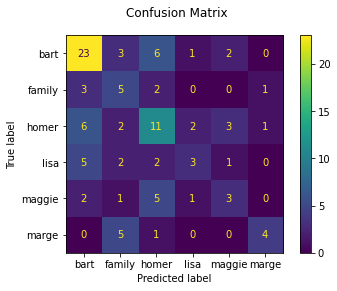

------------------------
Treinando LR
Evaluation of  LR
              precision    recall  f1-score   support

        bart       0.55      0.69      0.61        35
      family       0.54      0.64      0.58        11
       homer       0.47      0.56      0.51        25
        lisa       0.45      0.38      0.42        13
      maggie       0.50      0.17      0.25        12
       marge       0.75      0.30      0.43        10

    accuracy                           0.52       106
   macro avg       0.54      0.46      0.47       106
weighted avg       0.53      0.52      0.50       106




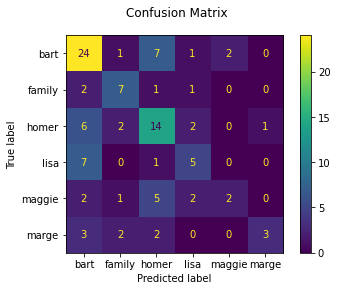

------------------------
Treinando SVC
Evaluation of  SVC
              precision    recall  f1-score   support

        bart       0.56      0.83      0.67        35
      family       0.60      0.55      0.57        11
       homer       0.50      0.52      0.51        25
        lisa       0.42      0.38      0.40        13
      maggie       0.50      0.08      0.14        12
       marge       1.00      0.40      0.57        10

    accuracy                           0.55       106
   macro avg       0.60      0.46      0.48       106
weighted avg       0.57      0.55      0.52       106




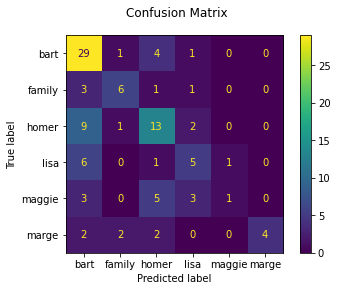

In [18]:
for name in models:
    print("------------------------")
    print(f"Treinando {name}")

    train = data_norm_train
    test = data_norm_test

    model = models[name]
    model.fit(train, y_train[:N_SAMPLES_TRAIN])
    predicted = model.predict(test)

    performance_evaluation(
        y_test[:N_SAMPLES_TEST], predicted, info_message=name, figsize=(10, 4)
    )

# Comentários: Percebemos que Bart é o personagem mais fácil de ser identificado, já maggie é a mais difícil, o melhor f1 score se deu com SVC com 0.55 e regressão logística com 0.52